# Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as  tf
import numpy as np
import itertools
from keras.optimizers import Adam
from keras.models import clone_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from functools import partial
import itertools
import random
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [2]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam

In [3]:
from tqdm import tqdm
import cv2

# Definitions

In [4]:
pwd

'/content'

In [5]:
base_path = "/content/drive/My Drive/Investigacion/UTN/GIAR/Dataset/cropped_cells_original"
save_path = "/content/drive/My Drive/Investigacion/UTN/GIAR/Results/Autoencoder/encoder_SSIM_MAE_Bparams.keras"

SHAPE = (128,128,1)
batch_size = 300
validation_split = 0.2

In [6]:
ON_RAM = False

# Load dataset

In [7]:

if ON_RAM:

    images = np.zeros((len(os.listdir(base_path)), SHAPE[0], SHAPE[1]))
    for idx, file in tqdm(enumerate(os.listdir(base_path)), total=len(os.listdir(base_path))):
        image = cv2.imread(os.path.join(base_path, file), cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (SHAPE[0], SHAPE[1]))
        image = np.array(image) #

        images[idx, : ,:] = image


    from sklearn.model_selection import train_test_split
    x_train, x_test = train_test_split(images, test_size=validation_split, random_state=42)
    x_train.shape

else:

    image_paths = list(tf.io.gfile.glob(base_path + '/*.png'))

    # Train / val split
    val_size = int(0.2 * len(image_paths))  # 20% para validación
    train_paths = image_paths[:-val_size]
    val_paths = image_paths[-val_size:]

    train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
    val_dataset = tf.data.Dataset.from_tensor_slices(val_paths)

    # Load & augmentation
    def load_image(path):

      image = tf.io.read_file(path)
      image = tf.image.decode_png(image, channels=1)  # Escala de grises
      image = tf.image.resize(image, (SHAPE[0], SHAPE[1]))
      # Augmentación

      image = tf.image.random_flip_left_right(image)
      image = tf.image.random_flip_up_down(image)
      image = tf.image.random_brightness(image, max_delta=0.1)
      image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
      scales = tf.random.uniform([], 0.8, 1.0)
      crop_size = tf.cast(scales * SHAPE[0], tf.int32)
      image = tf.image.random_crop(image, size=[crop_size, crop_size, 1])
      image = tf.image.resize(image, (SHAPE[0], SHAPE[1]))
      # Normalize [0, 1]
      image = tf.cast(image, tf.float32) / 255.0
      return image,image

    # Train dataset
    train_dataset = tf.data.Dataset.from_tensor_slices(train_paths)
    train_dataset = train_dataset.map(lambda x: load_image(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(buffer_size=10000)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    train_dataset = train_dataset.repeat()

    # Val dataset
    validation_dataset = val_dataset.map(lambda x: load_image(x), num_parallel_calls=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.batch(batch_size)
    validation_dataset = validation_dataset.prefetch(tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.repeat()




In [8]:
len(train_paths)

41322

# Weigthed Loss: SSIM + MAE

In [9]:
class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, y, z, name="custom_loss"):
        super().__init__(name=name)
        # Weights
        self.y = y
        self.z = z

        #MAE
        self.mae_loss_fn = tf.keras.losses.MeanAbsoluteError()

    # SSIM loss
    def ssim_loss(self, y_true, y_pred):

        ssim = (1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))) / 2
        return ssim

    def call(self, y_true, y_pred):

        mae_loss = self.mae_loss_fn(y_true, y_pred)
        ssim = self.ssim_loss(y_true, y_pred)


        return  self.y * mae_loss + self.z * ssim

# Autoencoder

In [10]:
kernel_size = (4,4)
filter = 32

# Encoder
encoder_input = layers.Input(shape=(128, 128, 1))

x = encoder_input

x = layers.Rescaling(1.0 / 255.0)(x)


x = layers.Conv2D(filter, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Conv2D(filter//2, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Conv2D(filter//4, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Conv2D(filter//8, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Conv2D(filter//16, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D((2, 2), padding='same')(x)

x = layers.Flatten()(x)

encoder_output = x


encoder = Model(encoder_input, encoder_output)

# Decoder

decoder_input = layers.Input(shape=[encoder.output_shape[-1]])

x = decoder_input

x = layers.Reshape((2*filter//16, 2*filter//16, filter//16))(x)


x = layers.Conv2D(filter//16, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(filter//8, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(filter//4, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(filter//2, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(filter, kernel_size, activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.UpSampling2D((2, 2))(x)

x = layers.Conv2D(1, kernel_size, activation='sigmoid', padding='same')(x)

#x = layers.Rescaling(255.0)(x)

decoder_output = x

decoder = Model(decoder_input, decoder_output)

# Build the autoencoder model
# autoencoder = Model(encoder_input, decoder_output)
autoencoder = Sequential([
    encoder,
    decoder
])

In [11]:
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 16)          │           8,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 8)           │           2,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 4)           │             516 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 4)           │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 4)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 2)             │             130 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 2)             │               8 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 2)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,702 (45.71 KB)

 Trainable params: 11,578 (45.23 KB)

 Non-trainable params: 124 (496.00 B)

In [12]:
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 2)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 4, 2)             │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 4, 4, 2)             │               8 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 2)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 8, 8, 4)             │             132 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 8, 8, 4)             │              16 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 16, 16, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 8)           │             520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 16, 16, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 32, 32, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 16)          │           2,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 64, 64, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 1)         │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,767 (45.96 KB)

 Trainable params: 11,643 (45.48 KB)

 Non-trainable params: 124 (496.00 B)

In [13]:
# Summary of the model
autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional (Functional)              │ (None, 32)                  │          11,702 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 128, 128, 1)         │          11,767 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,469 (91.68 KB)

 Trainable params: 23,221 (90.71 KB)

 Non-trainable params: 248 (992.00 B)

# Compile y fit: Best Params


In [14]:
loss_fn = CustomLoss(y=0.83, z=0.17)

steps_per_epoch = int(len(train_paths) // batch_size)
steps_per_epoch_val = int(len(val_paths) // batch_size)

autoencoder.compile(
    loss=loss_fn,
    optimizer=Adam(learning_rate=1e-3)
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=0
)

autoencoder.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    validation_data=validation_dataset,
    validation_steps=steps_per_epoch_val,
    callbacks=[early_stop],
    verbose=1
    )



Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 799s 560ms/step - loss: 0.1537 - val_loss: 0.2097
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 94s 552ms/step - loss: 0.1148 - val_loss: 0.2102
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 77s 562ms/step - loss: 0.1103 - val_loss: 0.2011
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 76s 559ms/step - loss: 0.1083 - val_loss: 0.1930
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 75s 551ms/step - loss: 0.1075 - val_loss: 0.1541
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 74s 540ms/step - loss: 0.1059 - val_loss: 0.2551
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 73s 535ms/step - loss: 0.1055 - val_loss: 0.1439
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 73s 536ms/step - loss: 0.1048 - val_loss: 0.1788
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 72s 528ms/step - loss: 0.1051 - val_loss: 0.2739
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 72s 530ms/step - loss: 0.1051 - val_loss: 0.3818
Epoch 11/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 72s 525ms/step - loss: 0.1041 - val_loss: 0.3775
Epoch 1

In [15]:
encoder.save(save_path)

# Results

<Axes: >

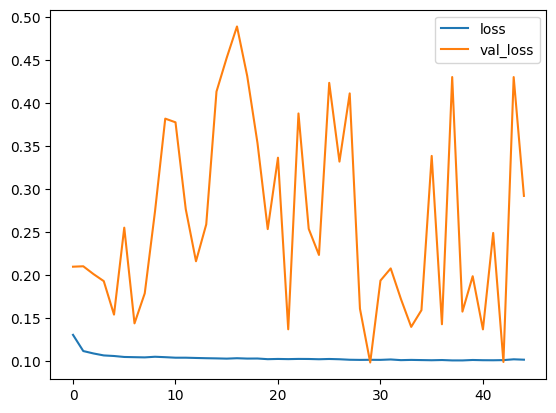

In [16]:
metrics = pd.DataFrame(autoencoder.history.history)
metrics[['loss', 'val_loss']].plot()

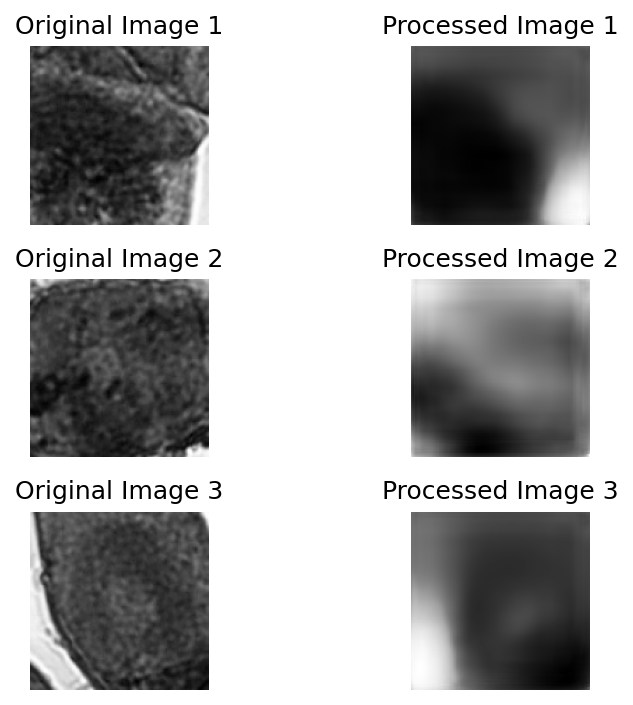

In [17]:
validation_images = validation_dataset.take(1)


for images, _ in validation_images:
    shuffled_images = tf.random.shuffle(images)
    first_three_images = shuffled_images[:3]
    break

processed_images = []
for img in first_three_images:
    img_with_batch = tf.expand_dims(img, axis=0)
    processed_image = autoencoder(img_with_batch).numpy()
    processed_images.append(processed_image.squeeze())

#Plot
n = 0
plt.figure(dpi=150)

plt.subplot(3, 2, 1)
plt.imshow(first_three_images[n], cmap='gray')  # Mostrar la imagen original
plt.axis(False)
plt.title(f"Original Image {n+1}")

plt.subplot(3, 2, 2)
plt.imshow(processed_images[n], cmap='gray')  # Mostrar la imagen procesada
plt.axis(False)
plt.title(f"Processed Image {n+1}")


n = 1
plt.subplot(3, 2, 3)
plt.imshow(first_three_images[n], cmap='gray')
plt.axis(False)
plt.title(f"Original Image {n+1}")

plt.subplot(3, 2, 4)
plt.imshow(processed_images[n], cmap='gray')
plt.axis(False)
plt.title(f"Processed Image {n+1}")


n = 2
plt.subplot(3, 2, 5)
plt.imshow(first_three_images[n], cmap='gray')
plt.axis(False)
plt.title(f"Original Image {n+1}")

plt.subplot(3, 2, 6)
plt.imshow(processed_images[n], cmap='gray')
plt.axis(False)
plt.title(f"Processed Image {n+1}")

plt.tight_layout()
plt.show()